In [1309]:
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from scipy.stats.mstats import winsorize
warnings.filterwarnings('ignore')

In [1310]:
def date_parser(_date):
    return pd.to_datetime(_date).date

def my_plot(df, columns=None):
    # prices = df[(df['postcode'] == 2607) & (df['propertyType'] == 'house')]['price']
    if columns is None:
        columns = ['price']
    elif columns == 'all':
        columns = df.columns

    nrows = len(columns)
    ncols = 1
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))
    for i, column in enumerate(columns):
        axs[i].plot(df.index, df[column])
        axs[i].set_title(column)
        axs[i].axhline(0, color='gray', linestyle='--', alpha=0.5)

        
############################################
    # plt.figure(figsize=(15,5))
    # plt.xticks(rotation=45)
    # plt.xticks(range(0, df.shape[0], 2))

    # for column in columns:
    #     prices = df[column]
    #     plt.plot(prices)
        
        

In [1311]:
df = pd.read_csv('data\\raw_sales.csv', index_col='datesold', date_parser=date_parser)
TRAINSET_SIZE = 0.75
BEDROOMS = 4
# df = df[df['bedrooms'] == BEDROOMS]
df.drop(columns=['postcode'], inplace=True)
df = df[df['propertyType'] == 'house']


In [1312]:
def expand_data(df, fillna=True, interpolate=False):
    df = df.pivot(columns=['bedrooms'], values='price')
    df = df.T.reset_index()
    # df['index'] = df.index.map(lambda x: (str(df.loc[x, 'propertyType']) + '_' + str(df.loc[x, 'bedrooms'])) )
    df['index'] = df.index.map(lambda x: ('_'.join([str(df.loc[x, 'bedrooms']), 'room'])) )
    df.set_index('index', inplace=True)
    df.drop(columns=['bedrooms'], inplace=True)
    df = df.T
    df.index = pd.to_datetime(df.index)
    df.dropna(axis=1, how='all', inplace=True)
    
    if fillna:
        for c in df.columns:
            if interpolate:
                df[c] = df[c].interpolate(method='polynomial', order=1)
                df[c] = df[c].fillna(df[c].mean())
            else:
                df[c] = df[c].fillna(df[c].mean())
                # df = df.fillna(df.mean())

            

    return df

In [1313]:
###### property type replace with numeric
propertyType = {'house': 1,
                'unit': 2}
# df.replace(propertyType, inplace=True)
df['date'] = [f'{y}-0{m}' if m < 10 else f'{y}-{m}' for y,m in list(zip(df.index.year, df.index.month))]
## choosing bedrooms
#### groupby month
df_groupped = df.groupby(by=['date', 'bedrooms']).mean()
df_groupped = df_groupped.reset_index(drop=False)
df_groupped.sort_values(by='date', ascending=True, inplace=True)
df_groupped.set_index('date', inplace=True)
df_groupped = expand_data(df_groupped, 
                          fillna=True,
                          interpolate=True)


# apply normalization



# df_train = normalize_data(df_train, columns=['price'])
# df_test = normalize_data(df_test, columns=['price'])
df_groupped

index,0_room,1_room,2_room,3_room,4_room,5_room
date,,,,,,
2007-02-01,679162.158455,356252.489349,473160.413453,290000.000000,525000.000000,8.724134e+05
2007-03-01,679162.158455,356252.489349,473160.413453,319000.000000,380000.000000,8.724134e+05
2007-04-01,679162.158455,356252.489349,473160.413453,399000.000000,997500.000000,8.724134e+05
2007-05-01,679162.158455,356252.489349,473160.413453,339500.000000,856434.426230,8.724134e+05
2007-06-01,679162.158455,356252.489349,473160.413453,345000.000000,710666.666667,8.724134e+05
...,...,...,...,...,...,...
2019-03-01,679162.158455,356252.489349,408333.333333,627037.974684,816174.698795,8.868333e+05
2019-04-01,679162.158455,356252.489349,555083.333333,637188.392857,783735.111111,1.017893e+06
2019-05-01,679162.158455,356252.489349,534833.333333,609584.677419,754035.802469,8.808158e+05


(150, 6)

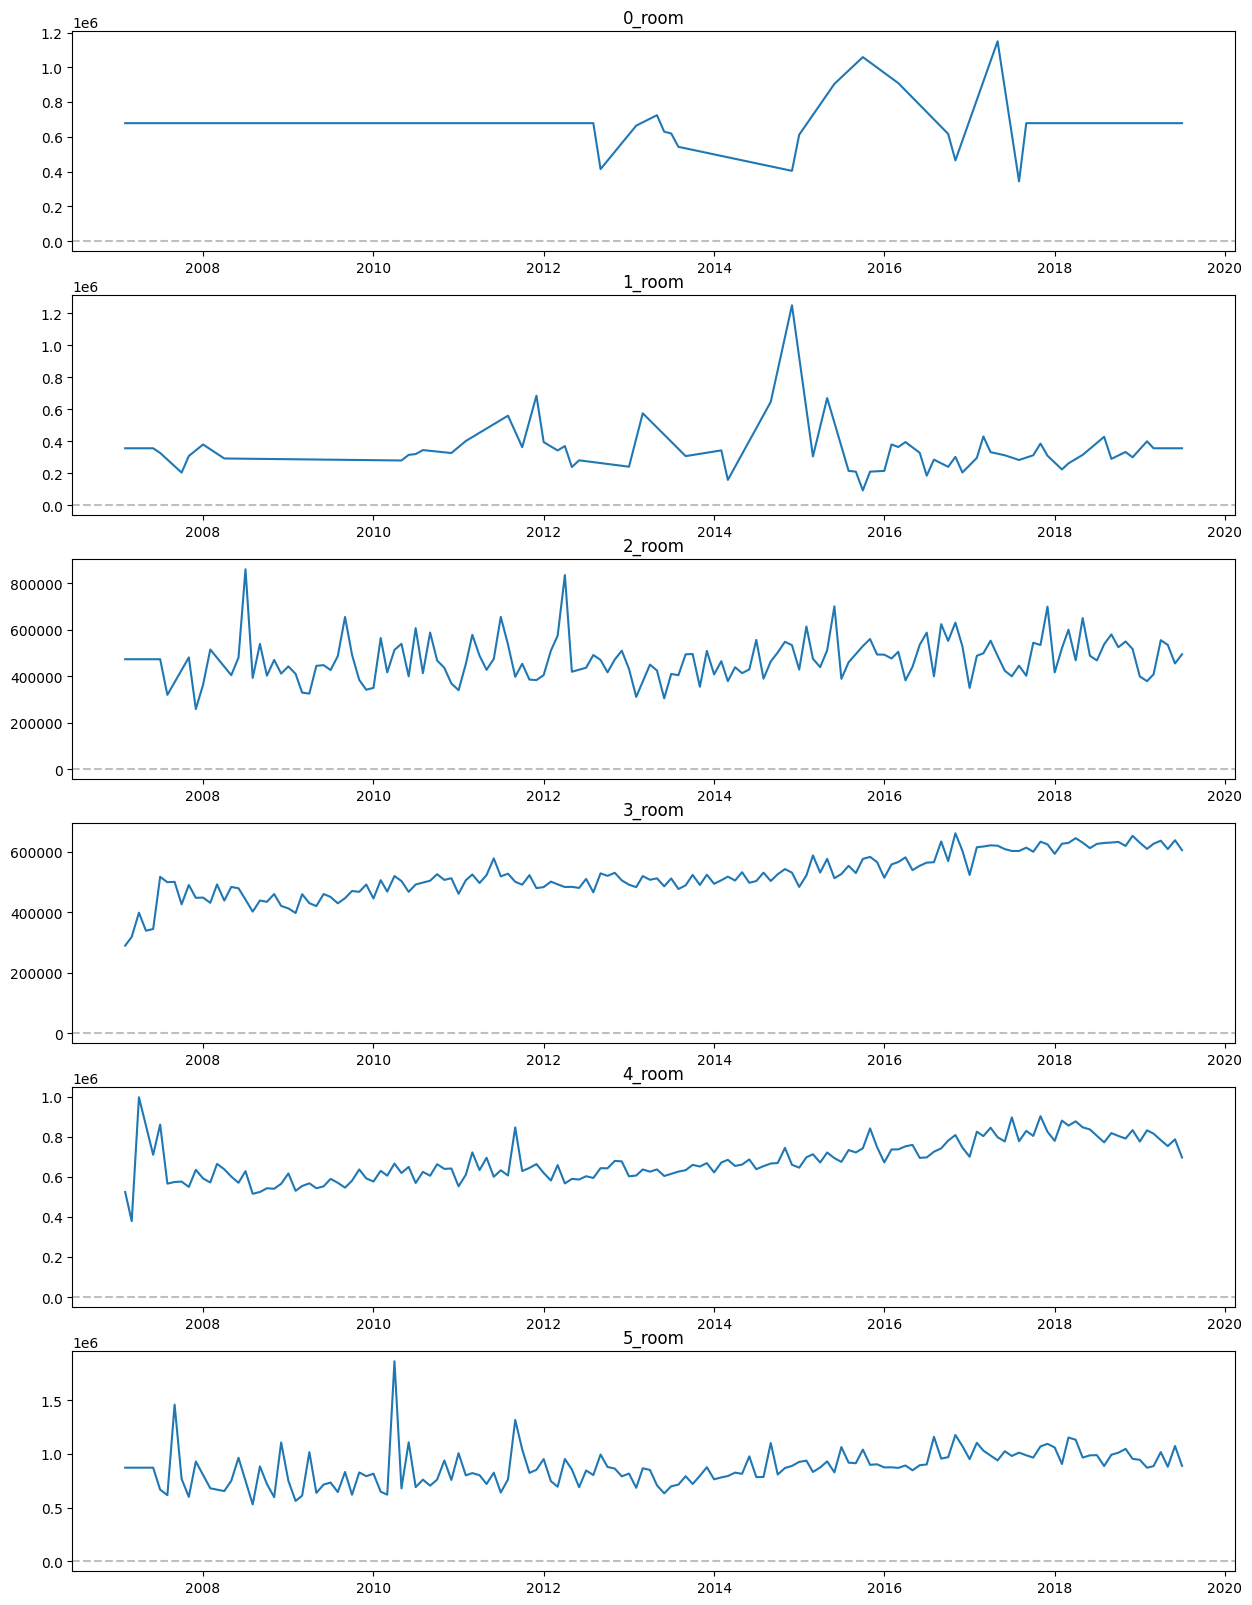

In [1314]:
my_plot(df_groupped, 'all')
df_groupped.shape

In [1315]:
df_groupped.drop(['0_room', '1_room'], axis=1, inplace=True)
# df_groupped = df_groupped[df_groupped.index.year >= 2011]

In [1316]:
split_point = int(df_groupped.shape[0]*TRAINSET_SIZE)
df_train = df_groupped.head(split_point)
df_test = df_groupped.tail(df_groupped.shape[0] - split_point)
print(df_groupped.shape)
print(df_test.shape, df_train.shape)
df_train.info(), df_test.info()



(150, 4)
(38, 4) (112, 4)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112 entries, 2007-02-01 to 2016-05-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2_room  112 non-null    float64
 1   3_room  112 non-null    float64
 2   4_room  112 non-null    float64
 3   5_room  112 non-null    float64
dtypes: float64(4)
memory usage: 4.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 2016-06-01 to 2019-07-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2_room  38 non-null     float64
 1   3_room  38 non-null     float64
 2   4_room  38 non-null     float64
 3   5_room  38 non-null     float64
dtypes: float64(4)
memory usage: 1.5 KB


(None, None)

In [1317]:
# differencing to remove trend
def diff_data(df, diff_step):
    df.sort_values(by='date', ascending=True, inplace=True)
    for column in df.columns:
        df[column] = df[column].diff(diff_step)
    # df.dropna(how='any', axis=0, inplace=True)
    df = df.tail(-diff_step)
    return df
    

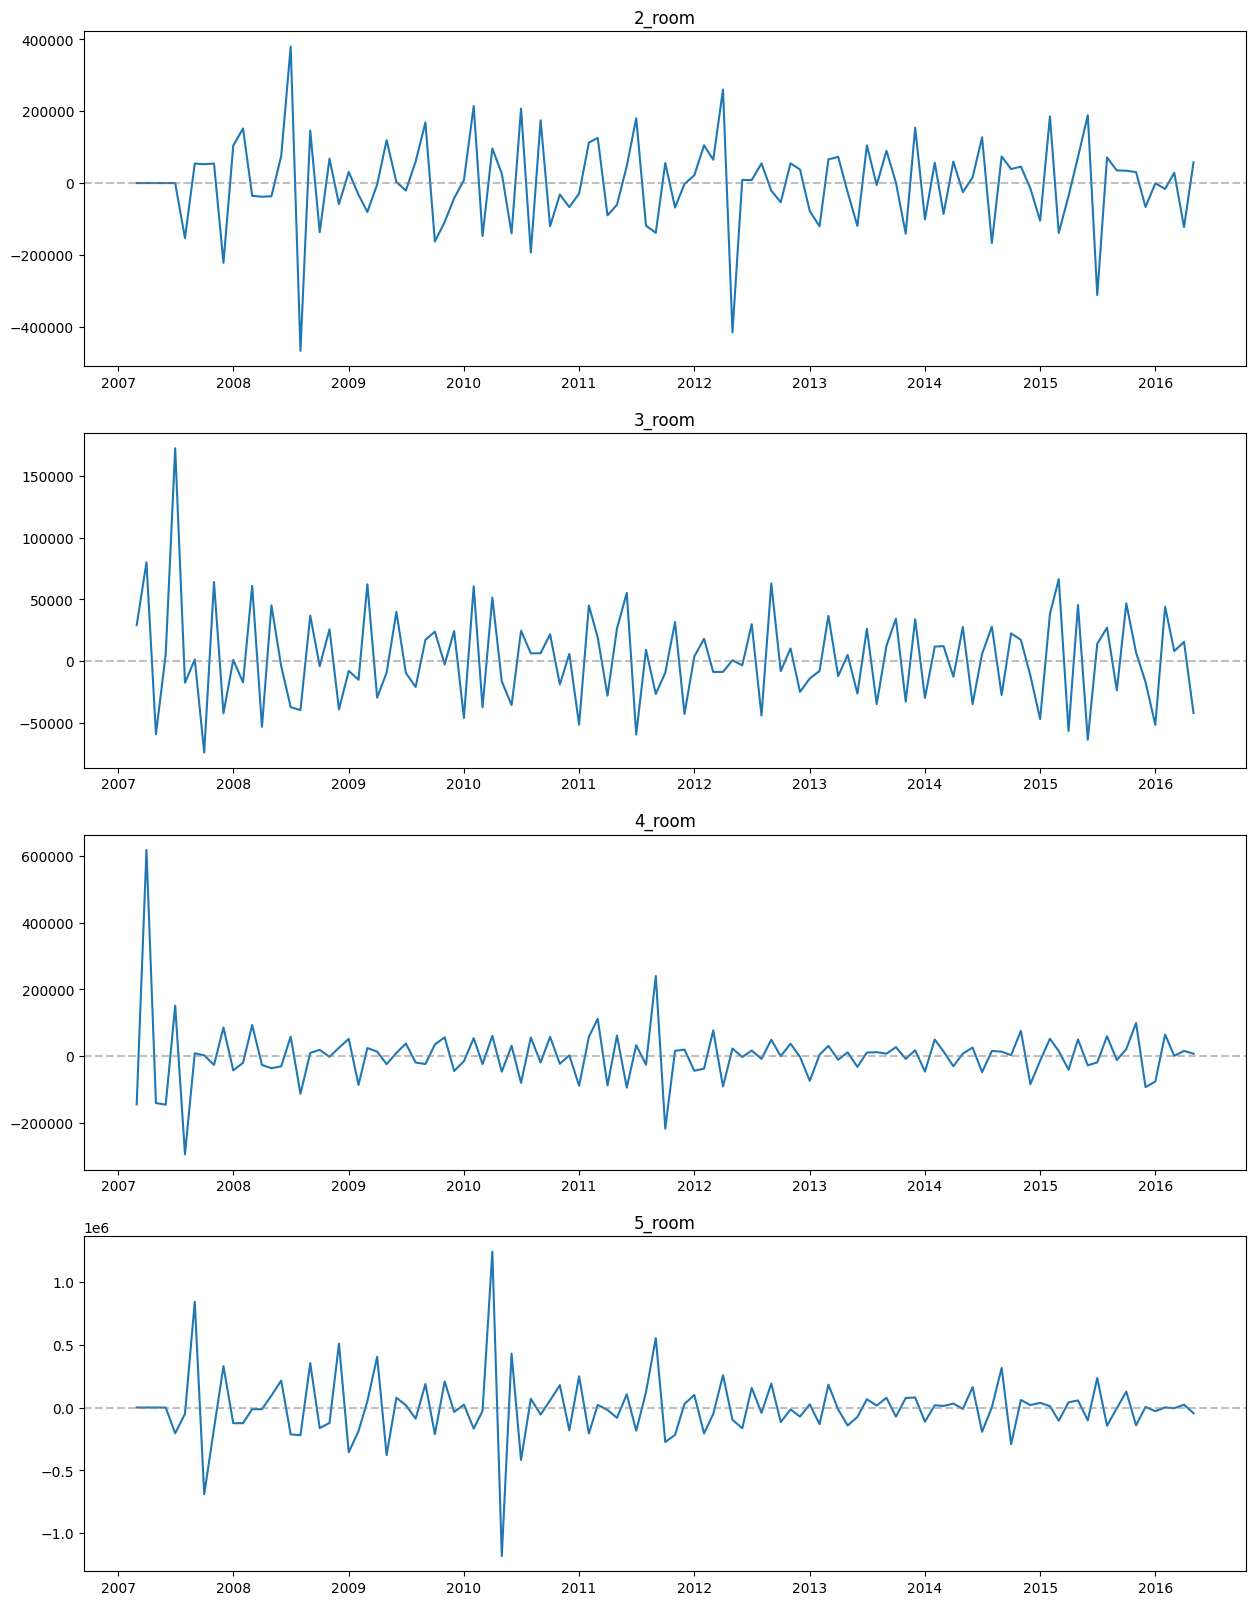

In [1318]:
df_train = diff_data(df_train, 1)
df_test = diff_data(df_test, 1)
my_plot(df_train, columns='all')


In [1319]:
## removing seasonality
def remove_seasonality(df):
        df_month_mean = df.groupby(by=df.index.month).mean()
        df_month_mean.reset_index(drop=False, inplace=True)
        df_month_mean.rename(columns={'date': 'month'}, inplace=True)
        df['month'] = df.index.month
        df.reset_index(drop=False, inplace=True)
        # df['price_month_mean'] = df.index.map(lambda x: df_month_mean.loc[int(x.split('-')[1]), 'price_mean'])
        # print(df)
        df = pd.merge(df, df_month_mean, on=['month'], how='left', suffixes=('', '_mean'))
        price_columns = [c for c in df.columns if '_mean' not in c and 'room' in c]
        for c in price_columns:
                c_mean = c+'_mean'
                df[c] = df[c] - df[c_mean]
                df.drop(c_mean, axis=1, inplace=True)
        df.set_index('date', inplace=True)
        df.drop(['month'], axis=1, inplace=True)
        df.index = pd.to_datetime(df.index).tz_localize(None)
        return df

In [1320]:
def normalize_data(df, columns=[], limits=False):
    if columns == 'all':
        columns = df.columns
    for c in columns:
        df[c]=(df[c]-df[c].mean())/df[c].std()
        if limits:
            df[c] = winsorize(df[c], limits=limits)
    return df

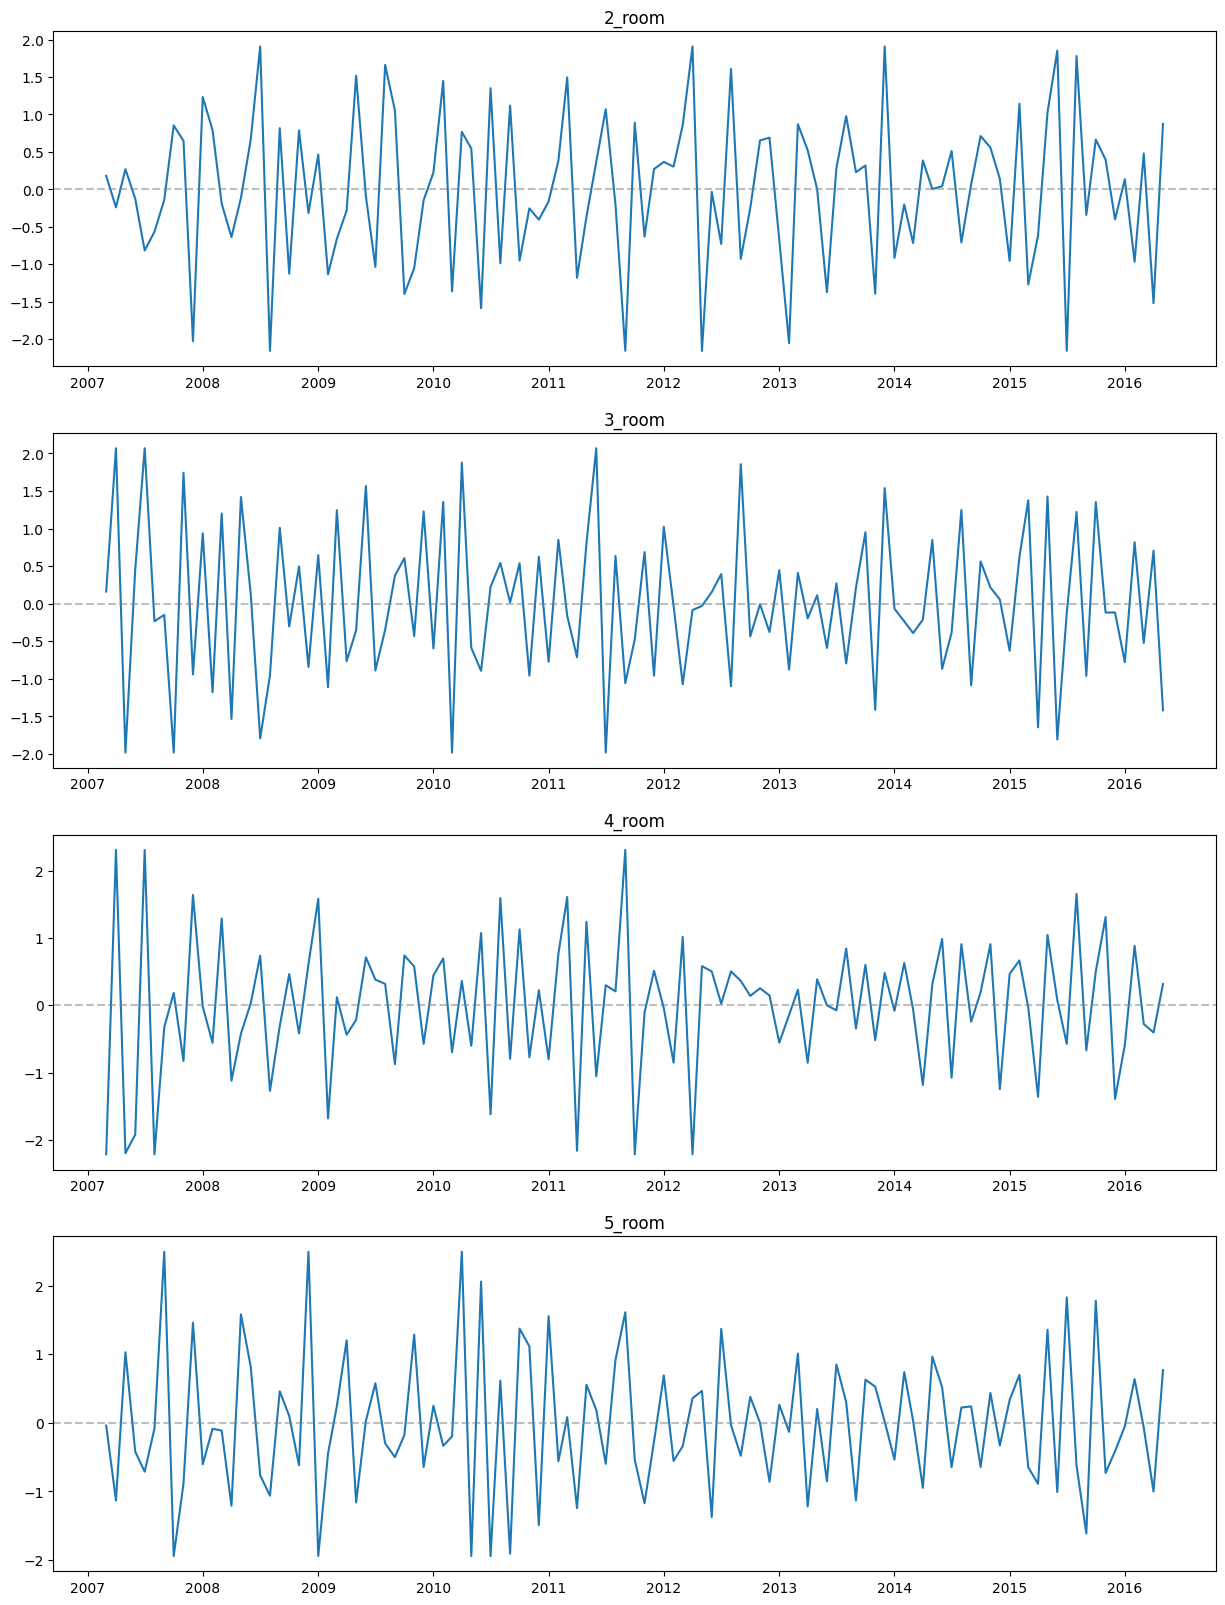

In [1321]:
df_train = remove_seasonality(df_train)
df_test = remove_seasonality(df_test)

df_train = normalize_data(df_train, columns='all', limits=(0.03, 0.02))
df_test = normalize_data(df_test, columns='all', limits=(0.03, 0.02))
df_train = normalize_data(df_train, columns='all')
df_test = normalize_data(df_test, columns='all')

my_plot(df_train, 'all')


In [1322]:



for c in df_train.columns:
    print(f'P-value ADF for {c}: {round(adfuller(df_train[c])[1], 4)}') 




P-value ADF for 2_room: 0.0
P-value ADF for 3_room: 0.0
P-value ADF for 4_room: 0.0391
P-value ADF for 5_room: 0.0


In [1323]:
def drop_columns(train, test):
    columns_to_drop = []
    if train.shape[1] > test.shape[1]:
        columns_to_drop = [c for c in train.columns if c not in test.columns]
    return columns_to_drop

In [1324]:
columns_to_drop = drop_columns(df_train, df_test)
columns_to_drop
# df_train.drop(columns_to_drop, axis=1, inplace=True)

[]

In [1325]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR

In [1326]:
target_column = '3_room'

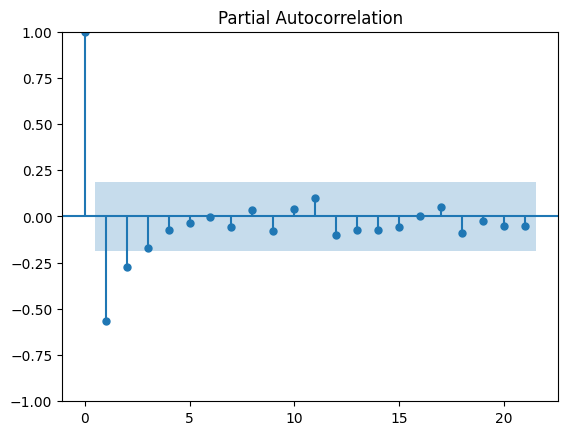

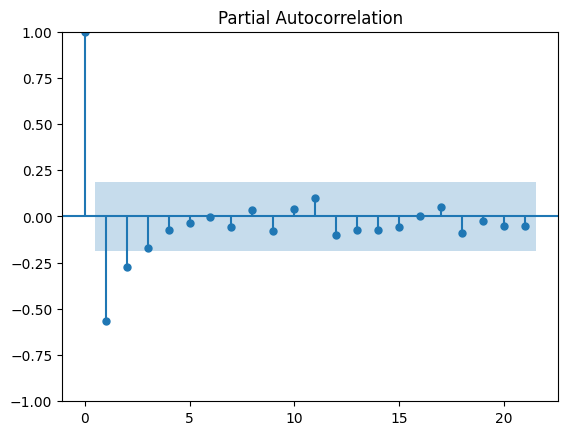

In [1327]:
plot_pacf(df_train[target_column])

In [1328]:
# plot_acf(df_train[target_column])


In [1329]:
# df_train = df_train[['unit_2', 'unit_4', target_column]]
# df_test = df_test[['unit_2', 'unit_4', target_column]]
lags = 1
model = VAR(df_train)
model_fit = model.fit(maxlags=lags)
model_fit.summary()



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Jan, 2024
Time:                     20:04:14
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                  -0.705449
Nobs:                     109.000    HQIC:                  -1.23386
Log likelihood:          -495.766    FPE:                   0.203350
AIC:                     -1.59434    Det(Omega_mle):        0.148055
--------------------------------------------------------------------
Results for equation 2_room
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000106         0.084961            0.001           0.999
L1.2_room        -0.388768         0.097692           -3.980           0.000
L1.3_room        -0.138022         0.111373           -1.239           0.21

In [1330]:
def forecast(model_fit, df_test):
    predictions = model_fit.forecast(steps=df_test.shape[0], y=df_test.values)
    df_predictions = pd.DataFrame(data=predictions, index=df_test.index, columns=df_test.columns.values)
    df_residuals = df_test - df_predictions
    return df_predictions, df_residuals

In [1331]:
## Rolling predictions
def forecast_rolling(df_train, df_test):
    df_predictions = pd.DataFrame()
    df_tain_rolling = df_train.copy()

    for i, row in df_test.iterrows():
        df_test_next = row.to_frame().T
        df_tain_rolling = pd.concat([df_tain_rolling, df_test_next], axis=0)
        model = VAR(df_tain_rolling)
        model_fit = model.fit(maxlags=lags)
        predictions = model_fit.forecast(steps=1, y=df_tain_rolling.tail(lags).values)
    
        # #get the predictions and residuals
        predictions = pd.DataFrame(data=predictions, index=[df_test_next.index[0] + relativedelta(months=1)], columns=df_test.columns.values)
        if df_predictions.empty:
            df_predictions = predictions
        else:
            df_predictions = pd.concat([df_predictions, predictions], axis=0)
        
    

    df_predictions = df_predictions.head(-1)
    df_test = df_test.tail(-1)
    df_residuals = df_test - df_predictions
    model_fit.is_stable(verbose=True)
    return df_predictions, df_residuals


Eigenvalues of VAR(1) rep
0.6241989300668958
0.6241989300668958
0.5182296677916938
0.5182296677916938
0.5616718892672863
0.5616718892672863
0.6257830085006466
0.6257830085006466


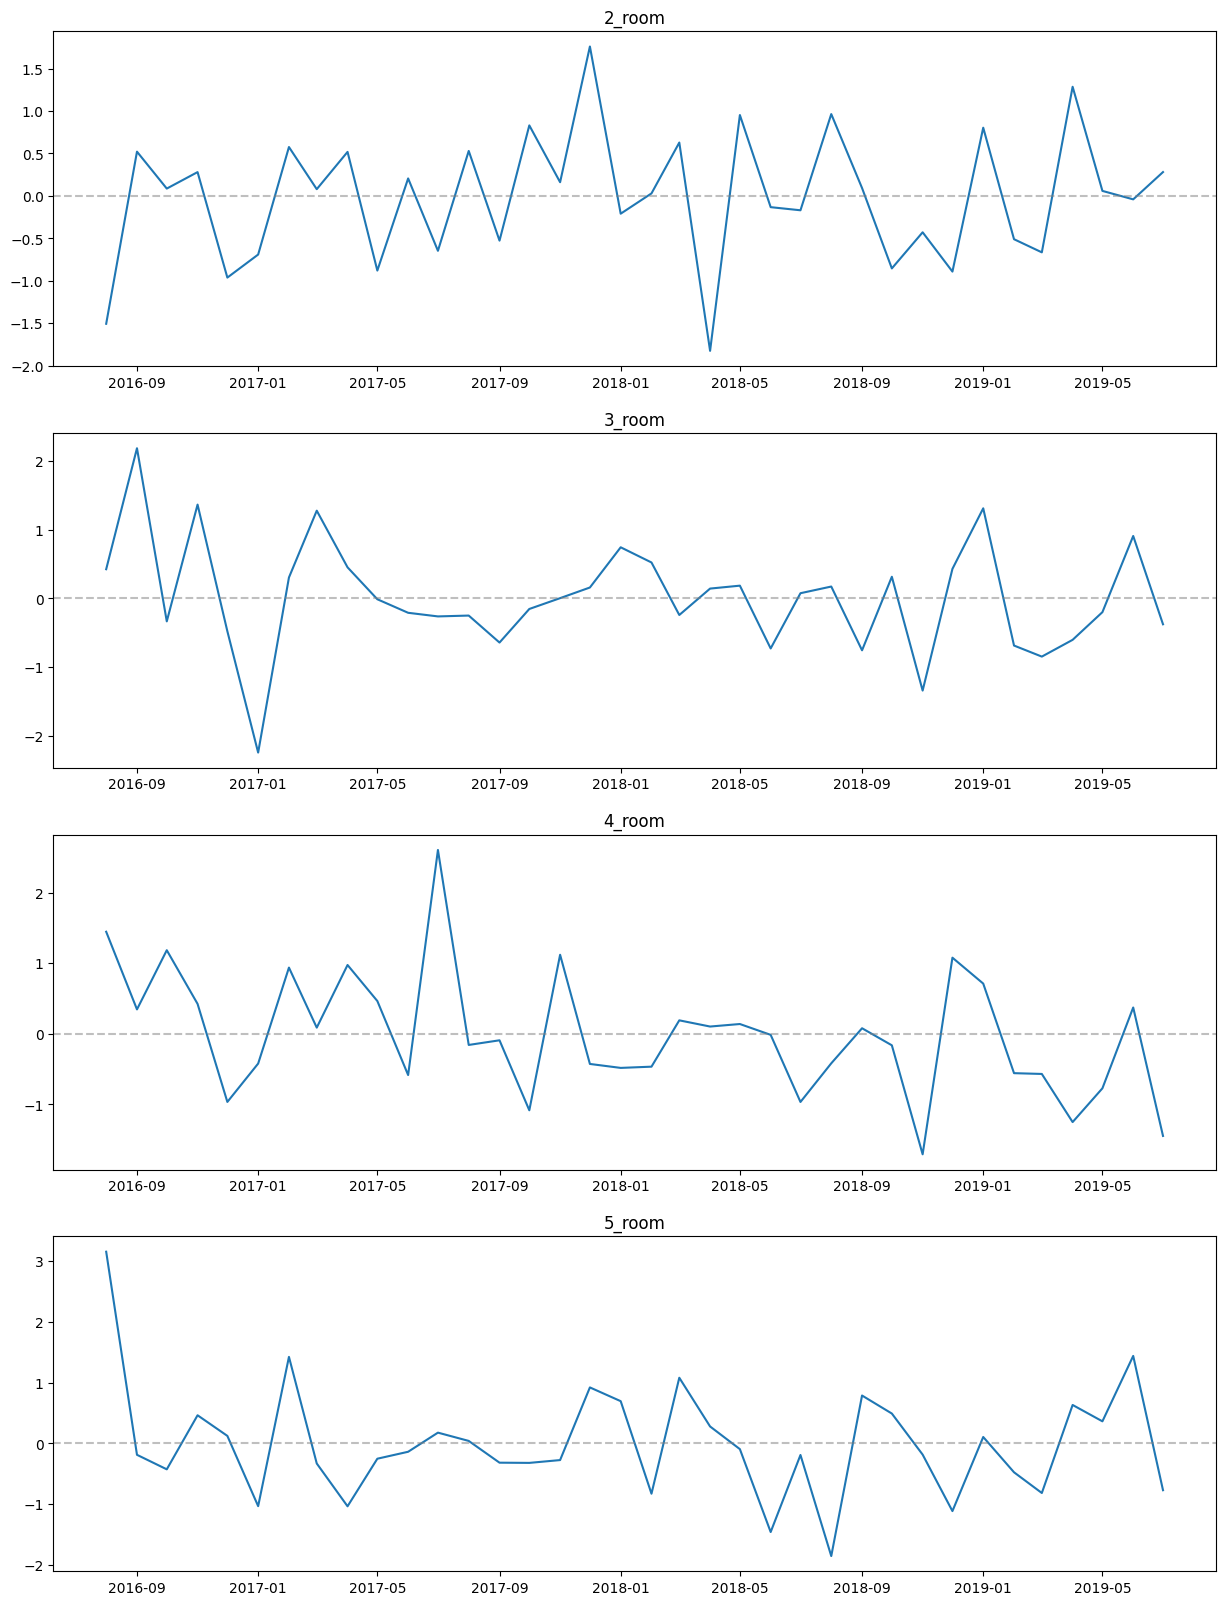

In [1332]:
# df_predictions, df_residuals = forecast(model_fit, df_test)
df_predictions, df_residuals = forecast_rolling(df_train, df_test)
my_plot(df_residuals, columns='all')


In [1333]:
df_data = pd.concat([df_train.tail(50), df_test], axis=0)

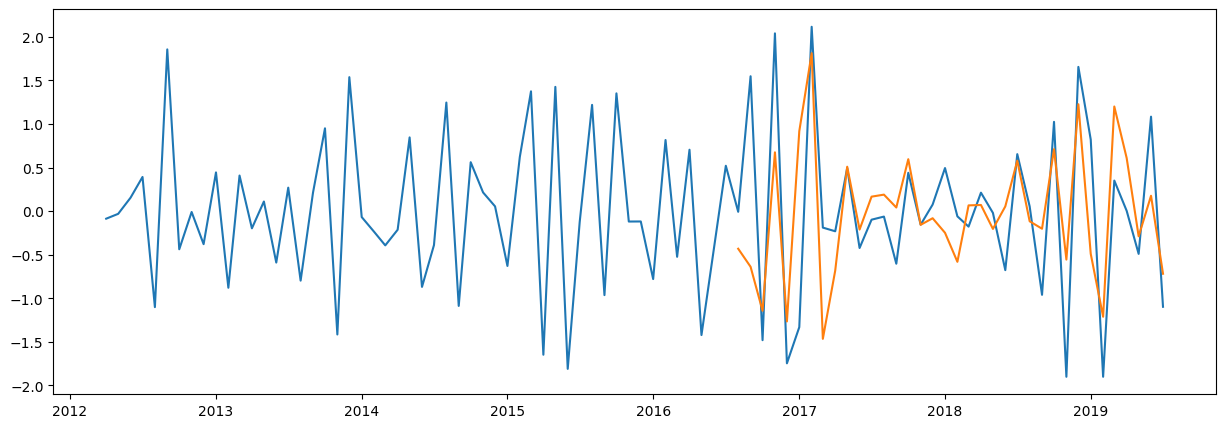

In [1334]:
plt.figure(figsize=(15,5))
plt.plot(df_data[target_column])
plt.plot(df_predictions[target_column])